# Query PS1 catalog database for moving targets

This notebook is available for <a href="ps1-moving-database-CADC.ipynb" download>download</a>.
In the future it will be incorporated into the [MAST notebooks repository](https://spacetelescope.github.io/mast_notebooks/intro.html).

This searches for Pan-STARRS1 catalog detections of the asteroid 
[**174361 Rickwhite (2002 TV315)**](https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=rickwhite&view=OPD).  The [CADC solar system image search](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/ssois/index.html#name) API is used to get an initial list of observations.  Then the [JPL Horizons database](https://ssd.jpl.nasa.gov/horizons/) is queried (using the `astroquery.jplhorizons` module) to get the position of the target as seen from the PS1 observatory on Mt Haleakala at the exact times of the PS1 observations.  Those positions are passed to the 
[PS1 CasJobs database](https://mastweb.stsci.edu/ps1casjobs) where they are cross-matched with the PS1 detection catalog.

For asteroid `rickwhite`, there are 93 potential observations identified. Image cutouts are extracted from all those images using the [ps1images](https://ps1images.stsci.edu) image cutout service.  30 images are blank because the object position falls in a chip gap or off the edge of the camera.  The 63 remaining images are displayed and show that the positions are indeed correct.  Some of the non-blank images still have gaps or other artifacts at the object position.

Using CasJobs, the PS1 catalog positions for the good images are queried and all matching detections from those images are returned.  46 matches are found for the 63 images.  

The time for all queries is about 1 minute (including the time to extract the image cutouts and to query the MAST database). The time and number of results returned should be roughly similar for most other solar system objects in the PS1 observing area.

Dependencies:

* `mastcasjobs` module to query MAST CasJobs database from Python
* `astroquery.jplhorizons` to access JPL Horizons ephemerides for objects
* `Pillow` (PIL image module) to read JPEG images
* Custom code is used to access the [CADC SSOS service](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/ssois/index.html#name)

*R. White, 2024 February 1*

## Imports and configuration

In [1]:
import astropy
from astropy.table import Table, join, vstack
from astropy.time import Time
from astropy.io import fits

from astroquery.jplhorizons import Horizons
import mastcasjobs
from PIL import Image, UnidentifiedImageError

import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import time
import requests
import sys
import os
import getpass

saveplots = False # set to save some of the plots to png files

In [2]:
# code to customize display
from IPython.display import display, Markdown, Latex, HTML

# Set page width to fill browser for longer output lines
# and make tables left-aligned
display(HTML("""
<style>
.container { width:100% !important; }
table { align:left; display:block; }
</style>
"""))
# set width for pprint
astropy.conf.max_width = 150

## Get and check CasJobs user login information

This uses the `CASJOBS_USERID` and `CASJOBS_PW` environment variables if they are defined.  If prompts for them if the environment variables are not defined.

If you do not have a CasJobs account, create one using the [MAST CasJobs website](https://mastweb.stsci.edu/ps1casjobs/).

In [3]:
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = input('Enter Casjobs UserID:')
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = getpass.getpass('Enter Casjobs password:')

jobs = mastcasjobs.MastCasJobs(context="MyDB")
print("Confirmed MAST CasJobs account access")

Confirmed MAST CasJobs account access


## Function to search moving object path using CADC

See the [CADC moving target API documentation](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/ssois/apidoc.html) for more details about the moving target search. 

In [1]:
def cadc_ssos_query(object_name, search="bynameCADC", 
                    epoch1=54985, epoch2=57079,
                    # epoch1=50985, epoch2=60079,
                    xyres="no", 
                    telinst="Pan-STARRS1", 
                    # telinst="SDSS",
                    lang="en", format="tsv",
                    url="https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl"):
    """Use CADC moving object query to find PS1 observations by target name
    
    The epoch parameters give the range in MJD for the PS1 observations.
    The only parameter that might be usefully modified is the search.  
    E.g., use search="bynameHorizons" to search using the JPL Horizons emphemeris rather
    than the ephemeris cached at CADC.  That might be useful if the CADC cache has become
    out-of-date.
    
    This return an astropy table with the observations.
    """
    r = requests.get(url, params=dict(lang=lang, object=object_name, 
                                    #   search=search,
                                      epoch1=epoch1, epoch2=epoch2, xyres=xyres,
                                      telinst=telinst, 
                                      format=format))
    r.raise_for_status()
    # raise exception for object not found
    msg = r.text.split('\n',1)[0]
    if msg.lower().find("not found") >= 0:
        if msg.lower().endswith("<br/>"):
            msg = msg[:-5]
            raise ValueError(f"Error from CADC search: {msg}")
    tab = Table.read(r.text, format="ascii.csv", delimiter="\t",
                     converters=dict(Image_target=str))
    return tab

## Functions to get images from PS1 cutout server

In [48]:
def getimages(tab, format="jpg", verbose=False, **kw):
    
    """Return list of images specified by the table with usual columns
    (projcell, subcell, image, ra and dec columns)
    
    Parameters:
    format = data format (options are "jpg", "png", "fits")
    verbose = if true, print progress info
    Other parameters passed on to tab2cutout:
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    racol, deccol, imagecol = names of table columns
    Returns the image as a PIL Image or an astropy fits hdulist
    """
    
    if format not in ("jpg", "png", "fits"):
        raise ValueError("format must be jpg, png or fits")
    urls = tab2cutout(tab, format=format, verbose=verbose, **kw)
    # print(urls)
    
    images = []
    if verbose:
        t0 = time.time()
        print(f"{time.time()-t0:.1f} s: completed 0 of {len(urls)} images", end="")
    for i, url in enumerate(urls,start=1):
        r = requests.get(url)
        if format == "fits":
            images.append(fits.open(BytesIO(r.content)))
        else:
            try:
                images.append(Image.open(BytesIO(r.content)))
            except UnidentifiedImageError as e:
                print(f"\nImage not found {url}")
                images.append(None)
        if verbose:
            print(f"\r{time.time()-t0:.1f} s: completed {i} of {len(urls)} images", end="")
    if verbose:
        print()
    return images


def tab2path(tab, imagecol='Image', verbose=False):
    """Convert table with usual columns (projcell, subcell, filter, expStart) to warp filter path
    
    Convert expStart from TAI to UTC for the file label
    
    Returns a list of file paths
    """
    for c in ('projcell','subcell',imagecol):
        assert c in tab.colnames, f"'{c}' column not found in table"
    rv = []
    for i, row in enumerate(tab):
        projcell = f"{row['projcell']:04d}"
        subcell = f"{row['subcell']:03d}"
        image = row[imagecol]
        rv.append(f"/rings.v3.skycell/{projcell}/{subcell}/{image}.fits")
    return rv


def tab2cutout(tab, size=64, output_size=256, format="jpg", autoscale=99.5, asinh=True,
               racol="ra", deccol="dec", imagecol="Image", verbose=False,
               urlbase="https://ps1images.stsci.edu/cgi-bin/fitscut.cgi"):
    """Convert table with usual columns (projcell, subcell, image, ra and dec columns) 
    to URL for warp image cutout
    
    Returns a list of URLs
    """
    for c in ('projcell', 'subcell', imagecol, racol, deccol):
        assert c in tab.colnames, f"'{c}' column not found in table"
    paths = tab2path(tab, imagecol=imagecol, verbose=verbose)
    # print(paths)
    rv = []
    for row, path in zip(tab, paths):
        params = dict(red=path, ra=row[racol], dec=row[deccol], size=size, format=format)
        if filter != "fits":
            # these parameters are used only for non-fits formats
            params['autoscale'] = autoscale
            if output_size is not None:
                params['output_size'] = output_size
            if asinh:
                params['asinh'] = 1
        sparams = '&'.join([f"{key}={str(value)}" for key, value in params.items()])
        # print(params)
        # print(sparams)
        rv.append(f"{urlbase}?{sparams}")
    return rv

## Functions to locate PanSTARRS skycell for a given RA/Dec

In [49]:
# pixel scale is 0.25 arcsec
pixscale = 0.25

# table of rings info
rings = Table.read("""zone projcell nband dec dec_min dec_max xcell ycell crpix1 crpix2
13 487 72 -38.0 -39.98569922229713 -35.98748871852416 6305 6279 239.5 238.0
14 559 76 -34.0 -35.98748871852416 -31.988947843740302 6265 6274 237.5 237.5
15 635 79 -30.0 -31.988947843740302 -27.990585819085737 6274 6269 239.5 241.5
16 714 82 -26.0 -27.990585819085737 -23.991856317278298 6255 6265 241.5 240.5
17 796 84 -22.0 -23.991856317278298 -19.99333106003115 6279 6261 241.0 242.0
18 880 86 -18.0 -19.99333106003115 -15.994464100667857 6274 6258 241.5 238.0
19 966 88 -14.0 -15.994464100667857 -11.995671545879146 6242 6254 240.5 239.5
20 1054 89 -10.0 -11.995671545879146 -7.997014822849273 6248 6250 240.0 242.0
21 1143 89 -6.0 -7.997014822849273 -3.998086931795508 6291 6247 237.5 240.0
22 1232 90 -2.0 -3.998086931795508 1.3877787807814457e-17 6240 6243 240.0 242.0
23 1322 90 2.0 1.3877787807814457e-17 3.998086931795508 6240 6243 240.0 242.0
24 1412 89 6.0 3.998086931795508 7.997014822849273 6291 6247 237.5 240.0
25 1501 89 10.0 7.997014822849273 11.995671545879146 6248 6250 240.0 242.0
26 1590 88 14.0 11.995671545879146 15.994464100667857 6242 6254 240.5 239.5
27 1678 86 18.0 15.994464100667857 19.99333106003115 6274 6258 241.5 238.0
28 1764 84 22.0 19.99333106003115 23.991856317278298 6279 6261 241.0 242.0
29 1848 82 26.0 23.991856317278298 27.990585819085737 6255 6265 241.5 240.5
30 1930 79 30.0 27.990585819085737 31.988947843740302 6274 6269 239.5 241.5
31 2009 76 34.0 31.988947843740302 35.98748871852416 6265 6274 237.5 237.5
32 2085 72 38.0 35.98748871852416 39.98569922229713 6305 6279 239.5 238.0
33 2157 68 42.0 39.98569922229713 43.98384988850235 6320 6284 239.5 240.0
34 2225 64 46.0 43.98384988850235 47.98179099058205 6307 6289 238.0 242.0
35 2289 60 50.0 47.98179099058205 51.97972846465295 6261 6295 241.0 239.5
36 2349 55 54.0 51.97972846465295 55.97676677254534 6283 6302 239.0 242.0
37 2404 50 58.0 55.97676677254534 59.97411834356914 6278 6311 238.5 237.5
38 2454 45 62.0 59.97411834356914 63.97005521318337 6240 6319 240.0 241.0
39 2499 39 66.0 63.97005521318337 67.96475284198297 6307 6333 239.5 240.0
40 2538 33 70.0 67.96475284198297 71.95817764373305 6365 6350 238.5 240.0
41 2571 27 74.0 71.95817764373305 75.94974140116577 6413 6371 240.5 242.0
42 2598 21 78.0 75.94974140116577 79.93968190571101 6452 6398 240.0 242.0
43 2619 15 82.0 79.93968190571101 83.93610604798963 6481 6429 241.0 242.0
44 2634 9 86.0 83.93610604798963 87.96940975734594 6501 6419 239.0 239.5
45 2643 1 90.0 87.96940975734594 90.0001 6240 6240 239.5 240.0
""", format="ascii.csv", delimiter=" ")

dec_limit = rings['dec_min'].min()

def findskycell(ra, dec):

    """Given input arrays RA, DEC (degrees), returns an astropy table with the skycell info

    RA and Dec can be scalars or arrays.
    This returns just the best sky cell for each ra/dec (the one where the position is closest to the center).
    This uses the rings table for info on the tessellation.
    The returned table has these columns:
    Column      Value
    ra          Input position
    dec         
    index       0-based index into original array
    projcell    Projection cell (0 if outside coverage)
    subcell     Subcell (0..99)
    crval1      Sky position of reference pixel for projection cell
    crval2      
    crpix1      Reference pixel in this skycell
    crpix2      
    x           Source pixel position in this skycell
    y           
    iring       Index into rings array
    """

    if np.isscalar(ra) and np.isscalar(dec):
        return _findskycell_array(np.array([ra]),np.array([dec]))
    if len(ra) == len(dec):
        return _findskycell_array(np.asarray(ra),np.asarray(dec))
    else:
        raise ValueError("ra and dec must both be scalars or be matching length arrays")


def _findskycell_array(ra, dec):

    """Internal function: ra and dec are known to be arrays"""

    if ra.ndim != 1 or dec.ndim != 1:
        raise ValueError("ra and dec must be 1-D arrays")
    index = np.arange(len(ra),dtype=int)
    # find dec zone where rings.dec_min <= dec < rings.dec_max
    idec = np.searchsorted(rings['dec_max'], dec)

    # special handling at pole where overlap is complicated
    # do extra checks for top 2 rings
    # always start with the ring just below the pole
    nearpole = np.where(idec >= len(rings)-2)
    idec[nearpole] = len(rings)-2

    nband = rings['nband'][idec]
    # get normalized RA in range 0..360
    nra = ra % 360.0
    ira = np.rint(nra*nband/360.0).astype(int) % nband

    projcell = rings['projcell'][idec] + ira
    dec_cen = rings['dec'][idec]
    ra_cen = ira*360.0/nband

    # locate subcell(s) within the projection cell

    # use tangent project to get pixel offsets
    x, y = sky2xy_tan(nra, dec, ra_cen, dec_cen)

    pad = 480

    if len(nearpole[0]) > 0:
        # handle the points near the pole (if any)
        # we know that this "ring" has only a single field
        projcell2 = rings['projcell'][-1]
        dec_cen2 = rings['dec'][-1]
        ra_cen2 = 0.0
        x2, y2 = sky2xy_tan(nra[nearpole], dec[nearpole], ra_cen2, dec_cen2)
        # compare x,y and x2,y2 to image sizes to select best image
        # returns a Boolean array with true for values where 2nd image is better
        use2 = poleselect(x[nearpole], y[nearpole], x2, y2, rings[-2], rings[-1], pad)
        if use2.any():
            # slightly obscure syntax here makes this work even if ra, dec are multi-dimensional
            wuse2 = np.where(use2)[0]
            w2 = tuple(xx[wuse2] for xx in nearpole)
            idec[w2] = len(rings)-1
            nband[w2] = 1
            ira[w2] = 0
            projcell[w2] = projcell2
            dec_cen[w2] = dec_cen2
            ra_cen[w2] = ra_cen2
            x[w2] = x2[wuse2]
            y[w2] = y2[wuse2]

    # compute the subcell from the pixel location
    px = rings['xcell'][idec]-pad
    py = rings['ycell'][idec]-pad
    k = np.rint(4.5+x/px).astype(int).clip(0,9)
    j = np.rint(4.5+y/py).astype(int).clip(0,9)
    subcell = 10*j + k

    # get pixel coordinates within the skycell image
    crpix1 = rings['crpix1'][idec] + px*(5-k)
    crpix2 = rings['crpix2'][idec] + py*(5-j)
    ximage = x + crpix1
    yimage = y + crpix2
    iring = idec

    # insert zeros where we are below lowest dec_min
    w = np.where(dec < dec_limit)
    projcell[w] = 0
    subcell[w] = 0
    crpix1[w] = 0
    crpix2[w] = 0
    ximage[w] = 0
    yimage[w] = 0

    # return an astropy Table
    return Table([ra,dec,index,projcell,subcell,ra_cen,dec_cen,crpix1,crpix2,ximage,yimage,iring],
                 names="ra,dec,index,projcell,subcell,crval1,crval2,crpix1,crpix2,x,y,iring".split(","))


def poleselect(x1, y1, x2, y2, rings1, rings2, pad):

    """Compares x,y values from 2 images to determine which is best

    Returns boolean array with True where x2,y2 is best
    """

    nx1 = 10*(rings1['xcell']-pad)+pad
    ny1 = 10*(rings1['ycell']-pad)+pad
    nx2 = 10*(rings2['xcell']-pad)+pad
    ny2 = 10*(rings2['ycell']-pad)+pad
    # compute minimum distances to image edges
    # note negative values are off edge
    d1 = np.minimum(np.minimum(x1+nx1//2,nx1//2-1-x1), np.minimum(y1+ny1//2,ny1//2-1-y1))
    d2 = np.minimum(np.minimum(x2+nx2//2,nx2//2-1-x2), np.minimum(y2+ny2//2,ny2//2-1-y2))
    return (d1 < d2)


def sky2xy_tan(ra, dec, ra_cen, dec_cen, crpix=(0.0,0.0)):

    """Convert RA,Dec sky position (degrees) to X,Y pixel position

    ra[n], dec[n] are input arrays in degrees
    ra_cen[n], dec_cen[n] are image centers in degrees
    crpix is the reference pixel position (x,y)
    Returns tuple (x,y) where x and y are arrays with pixel position for each RA,Dec
    """

    dtor = np.pi/180
    cd00 = -pixscale*dtor/3600
    cd01 = 0.0
    cd10 = 0.0
    cd11 = -cd00
    determ = cd00*cd11-cd01*cd10
    cdinv00 =  cd11/determ
    cdinv01 = -cd01/determ
    cdinv10 = -cd10/determ
    cdinv11 =  cd00/determ

    cos_crval1 = np.cos(dtor*dec_cen)
    sin_crval1 = np.sin(dtor*dec_cen)

    radif = (ra - ra_cen)*dtor
    w = np.where(radif > np.pi)
    radif[w] -= 2*np.pi
    w = np.where(radif < -np.pi)
    radif[w] += 2*np.pi

    decrad = dec*dtor
    cos_dec = np.cos(decrad)
    sin_dec = np.sin(decrad)
    cos_radif = np.cos(radif)
    sin_radif = np.sin(radif)
    h = sin_dec*sin_crval1 + cos_dec*cos_crval1*cos_radif
    xsi = cos_dec*sin_radif/h
    eta = (sin_dec*cos_crval1 - cos_dec*sin_crval1*cos_radif)/h
    xdif = cdinv00*xsi + cdinv01*eta
    ydif = cdinv10*xsi + cdinv11*eta
    return (xdif+crpix[0], ydif+crpix[1])


def xy2sky_tan(x, y, ra_cen, dec_cen, crpix=(0.0,0.0)):

    """Convert X,Y pixel position to RA,Dec sky position (degrees)

    x[n], y[n] are input arrays in pixels
    ra_cen[n], dec_cen[n] are image centers in degrees
    crpix is the reference pixel position (x,y)
    Returns tuple (ra,dec) where ra and dec are arrays with pixel position for each x,y
    """

    dtor = np.pi/180
    cd00 = -pixscale*dtor/3600
    cd01 = 0.0
    cd10 = 0.0
    cd11 = -cd00

    cos_crval1 = np.cos(dtor*dec_cen)
    sin_crval1 = np.sin(dtor*dec_cen)

    xdif = x - crpix[0]
    ydif = y - crpix[1]
    xsi = cd00*xdif + cd01*ydif
    eta = cd10*xdif + cd11*ydif
    beta = cos_crval1 - eta*sin_crval1
    ra = np.arctan2(xsi, beta) + dtor*ra_cen
    gamma = np.sqrt(xsi**2 + beta**2)
    dec = np.arctan2(eta*cos_crval1+sin_crval1, gamma)
    return (ra/dtor, dec/dtor)

## Get image list from CADC moving object query <a name="start"></a>

This query takes about 10 seconds.

In [50]:
%%time 

# source = "rickwhite"

# some other sample objects
# source = "33798"       # fast-moving object, 10 arcsec/hour
# source = "134340"      # Pluto
# source = "2003 YT1"    # asteroid that passes close to North Celestial Pole (only 2 epochs in PS1)
# source = "Cruithne"    # fast-moving, unusual Earth-associated orbit
# source = "5261"        # Mars-trojan asteroid
source = "33931"         # 243 Ida, first asteroid known to have a moon
# source = "34583"

cadc_tab = cadc_ssos_query(source)
print(f"Returned table has {len(cadc_tab)} rows")
cadc_tab

Returned table has 114 rows
CPU times: user 12.1 ms, sys: 1 ms, total: 13.1 ms
Wall time: 4.02 s


<Table length=114>
                   Image                          MJD        Filter Exptime    Object_RA     ... Image_target Telescope/Instrument MetaData Datalink
                   str43                        float64       str1   int64      float64      ...     str8            str11          int64    int64  
------------------------------------------- ---------------- ------ ------- ---------------- ... ------------ -------------------- -------- --------
rings.v3.skycell.0933.066.wrp.y.55240_62785 55240.6284241111      y      30 221.367714610025 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.066.wrp.y.55240_62935 55240.6299234111      y      30   221.3680006015 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.066.wrp.y.55240_63602 55240.6365871111      y      30 221.369271702275 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.066.wrp.y.55240_63751 55240.6380881111      y      30 221.369558018026 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_61053 55253.6111074111      z      30 223.400384162278 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_61171 55253.6122903111      z      30 223.400527657906 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_62023 55253.6208079111      z      30 223.401560913766 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_62138 55253.6219536111      z      30 223.401699896723 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.074.wrp.r.55298_47205 55298.4726590333      r      36 221.915647098481 ...     0933.074          Pan-STARRS1       --       --
                                        ...              ...    ...     ...              ... ...          ...                  ...      ...      ...
rings.v3.skycell.1131.039.wrp.i.56874_44757 56874.4482354167      i      45 309.514342954491 ...     1131.039          Pan-STARRS1       --       --
rings.v3.skycell.1131.039.wrp.i.56874_45773 56874.4584074167      i      45 309.512149320307 ...     1131.039          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_42344 56885.4241125167      i      45   307.3208895347 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_42344 56885.4241125167      i      45   307.3208895347 ...     1130.025          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_43654 56885.4372134167      i      45 307.318660853263 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_43654 56885.4372134167      i      45 307.318660853263 ...     1130.025          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_44963 56885.4502974167      i      45 307.316435046796 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_44963 56885.4502974167      i      45 307.316435046796 ...     1130.025          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_46267 56885.4633477167      i      45 307.314214973261 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_46267 56885.4633477167      i      45 307.314214973261 ...     1130.025          Pan-STARRS1       --       --

In [37]:
cadc_df = cadc_tab.to_pandas()
cond = cadc_df['Filter'].str.contains('g')
cadc_df[cond]

Image           MJD Filter  Exptime  \
12  rings.v3.skycell.0933.097.wrp.g.55303_53595  55303.536652      g       52   
13  rings.v3.skycell.0933.097.wrp.g.55303_54596  55303.546664      g       52   
20  rings.v3.skycell.1019.059.wrp.g.55328_39466  55328.395311      g       43   
21  rings.v3.skycell.1019.059.wrp.g.55328_39721  55328.397863      g       43   
22  rings.v3.skycell.1019.059.wrp.g.55328_40575  55328.406397      g       43   
23  rings.v3.skycell.1019.059.wrp.g.55328_40837  55328.409012      g       43   
34  rings.v3.skycell.1692.050.wrp.g.55889_52097  55889.521619      g       43   
35  rings.v3.skycell.1692.050.wrp.g.55889_53339  55889.534038      g       43   
40  rings.v3.skycell.1692.044.wrp.g.55896_47705  55896.477702      g       43   
41  rings.v3.skycell.1692.044.wrp.g.55896_49051  55896.491152      g       43   
61  rings.v3.skycell.1275.063.wrp.g.56310_58534  56310.585995      g       43   
62  rings.v3.skycell.1275.063.wrp.g.56310_58608  56310.586742      g       43   
63  rings.v3.skycell.1275.063.wrp.g.56310_59729  56310.597953      g       43   
64  rings.v3.skycell.1275.063.wrp.g.56310_59803  56310.598698      g       43   
73  rings.v3.skycell.1274.080.wrp.g.56336_51985  56336.520509      g       43   
74  rings.v3.skycell.1274.080.wrp.g.56336_52049  56336.521140      g       43   
75  rings.v3.skycell.1274.080.wrp.g.56336_53140  56336.532057      g       43   
76  rings.v3.skycell.1274.080.wrp.g.56336_53203  56336.532687      g       43   

     Object_RA  Object_Dec Image_target Telescope/Instrument  MetaData  \
12  220.893150  -16.348405     0933.097          Pan-STARRS1      <NA>   
13  220.890964  -16.347471     0933.097          Pan-STARRS1      <NA>   
20  214.929541  -13.719069     1019.059          Pan-STARRS1      <NA>   
21  214.928955  -13.718795     1019.059          Pan-STARRS1      <NA>   
22  214.926994  -13.717879     1019.059          Pan-STARRS1      <NA>   
23  214.926393  -13.717598     1019.059          Pan-STARRS1      <NA>   
34   60.522328   18.342475     1692.050          Pan-STARRS1      <NA>   
35   60.518897   18.341457     1692.050          Pan-STARRS1      <NA>   
40   58.648693   17.786888     1692.044          Pan-STARRS1      <NA>   
41   58.645205   17.785854     1692.044          Pan-STARRS1      <NA>   
61  172.597798   -1.575305     1275.063          Pan-STARRS1      <NA>   
62  172.597777   -1.575310     1275.063          Pan-STARRS1      <NA>   
63  172.597465   -1.575394     1275.063          Pan-STARRS1      <NA>   
64  172.597445   -1.575399     1275.063          Pan-STARRS1      <NA>   
73  169.775232   -0.753470     1274.080          Pan-STARRS1      <NA>   
74  169.775114   -0.753424     1274.080          Pan-STARRS1      <NA>   
75  169.773060   -0.752627     1274.080          Pan-STARRS1      <NA>   
76  169.772941   -0.752581     1274.080          Pan-STARRS1      <NA>   

    Datalink  
12      <NA>  
13      <NA>  
20      <NA>  
21      <NA>  
22      <NA>  
23      <NA>  
34      <NA>  
35      <NA>  
40      <NA>  
41      <NA>  
61      <NA>  
62      <NA>  
63      <NA>  
64      <NA>  
73      <NA>  
74      <NA>  
75      <NA>  
76      <NA>

In [14]:
cadc_df.value_counts('Telescope/Instrument')

Telescope/Instrument
Pan-STARRS1    114
Name: count, dtype: int64

In [15]:
cadc_df.value_counts(['Telescope/Instrument', 'Filter'])

Telescope/Instrument  Filter
Pan-STARRS1           i         33
                      z         25
                      y         22
                      g         18
                      r         16
Name: count, dtype: int64

## Recompute positions using accurate epochs

The interpolated positions from CADC can be off by a few arcsec, so recompute them using JPL Horizons at the exact times of the PS1 observations.

The location code `F51` corresponds to the 
[Pan-STARRS 1 observatory on Mt. Haleakala](https://en.wikipedia.org/wiki/List_of_observatory_codes).  The object positions are converted to RA and Dec as seen from the observatory.

Note that Horizons uses times in UTC rather than TAI (which is what is in the PS1 database).  Appending `TT` to the start time is supposed to cause Horizons to use TT (= TAI $\pm0.002$ s), but that triggers some kind of parsing bug in the `astroquery.Horizons` module.  Do the queries in UTC instead.

Divide this query into groups of 50 JD values to avoid errors from the service.

This query takes about 1 second.

In [51]:
# convert input epochs from TAI to UTC
jdepochs = Time(cadc_tab["MJD"],scale="tai",format="mjd").utc.jd.tolist()
tlist = []
block = 50
for k in range(0,len(jdepochs),block):
    obj = Horizons(id=source, location='F51', epochs=jdepochs[k:k+block])
    tlist.append(obj.ephemerides(extra_precision=True))
tab2 = vstack(tlist)
fullname = tab2['targetname'][0]
print(f"Got positions from Horizons for {len(jdepochs)} epochs with {len(tab2)} rows for {fullname}")
assert np.allclose(jdepochs, tab2['datetime_jd'].data)
# convert output epochs from UTC back to TAI for PS1 database matching
t2 = Time(tab2['datetime_jd'].data,format='jd',scale='utc').tai.mjd
assert np.allclose(t2,cadc_tab["MJD"].data)
#  = tab2.to_pandas()
tab2

Got positions from Horizons for 114 epochs with 114 rows for 33931 Alexeysergeyev (2000 LW28)


<Table length=114>
           targetname                  datetime_str          datetime_jd       H       G    ... true_anom  hour_angle  alpha_true  PABLon   PABLat
              ---                          ---                    d           mag     ---   ...    deg         h          deg       deg      deg  
             str32                        str24                float64      float64 float64 ...  float64    float64     float64   float64  float64
-------------------------------- ------------------------ ----------------- ------- ------- ... --------- ------------ ---------- -------- -------
33931 Alexeysergeyev (2000 LW28) 2010-Feb-13 15:04:21.843  2455241.12803059   15.27    0.15 ...   231.084 -0.542412401    22.6225 212.9611 -1.3567
33931 Alexeysergeyev (2000 LW28) 2010-Feb-13 15:06:31.383 2455241.129529892   15.27    0.15 ...  231.0844 -0.506348968    22.6224 212.9614 -1.3567
33931 Alexeysergeyev (2000 LW28) 2010-Feb-13 15:16:07.126 2455241.136193593   15.27    0.15 ...  231.0859 -0.346063774    22.6221 212.9628 -1.3567
33931 Alexeysergeyev (2000 LW28) 2010-Feb-13 15:18:16.813 2455241.137694593   15.27    0.15 ...  231.0862 -0.309959491     22.622 212.9631 -1.3566
33931 Alexeysergeyev (2000 LW28) 2010-Feb-26 14:39:25.680 2455254.110713893   15.27    0.15 ...  234.1061 -0.240605524    21.5963 215.4682 -1.2063
33931 Alexeysergeyev (2000 LW28) 2010-Feb-26 14:41:07.883 2455254.111896792   15.27    0.15 ...  234.1064 -0.212147125    21.5962 215.4684 -1.2063
33931 Alexeysergeyev (2000 LW28) 2010-Feb-26 14:53:23.804 2455254.120414393   15.27    0.15 ...  234.1084 -0.007229258    21.5951 215.4699 -1.2062
33931 Alexeysergeyev (2000 LW28) 2010-Feb-26 14:55:02.792 2455254.121560093   15.27    0.15 ...  234.1086  0.020334191    21.5949   215.47 -1.2062
33931 Alexeysergeyev (2000 LW28) 2010-Apr-12 11:20:03.740 2455298.972265515   15.27    0.15 ...  244.9864 -0.516615602     9.0229 220.0524 -0.4868
                             ...                      ...               ...     ...     ... ...       ...          ...        ...      ...     ...
33931 Alexeysergeyev (2000 LW28) 2014-Aug-05 10:59:31.401 2456874.958002324   15.27    0.15 ...  340.8343  0.855191915     4.5293 310.1144  5.6919
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 10:10:08.321 2456885.923707424   15.27    0.15 ...  345.2974  0.898474286     9.4928 311.2204  5.6204
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 10:10:08.321 2456885.923707424   15.27    0.15 ...  345.2974  0.898474286     9.4928 311.2204  5.6204
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 10:29:00.239 2456885.936808324   15.27    0.15 ...  345.3028  1.213924213        9.5 311.2218  5.6203
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 10:29:00.239 2456885.936808324   15.27    0.15 ...  345.3028  1.213924213        9.5 311.2218  5.6203
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 10:47:50.697 2456885.949892324   15.27    0.15 ...  345.3081  1.528966829     9.5071 311.2231  5.6202
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 10:47:50.697 2456885.949892324   15.27    0.15 ...  345.3081  1.528966829     9.5071 311.2231  5.6202
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 11:06:38.243 2456885.962942624   15.27    0.15 ...  345.3134  1.843197524     9.5142 311.2245  5.6201
33931 Alexeysergeyev (2000 LW28) 2014-Aug-16 11:06:38.243 2456885.962942624   15.27    0.15 ...  345.3134  1.843197524     9.5142 311.2245  5.6201

## Add new positions and differences to cadc_tab

Also add the `illumination` (illumination percentage) and `delta` (range to object in AU), which are useful to understand apparent brightness.

In [52]:
cadc_tab

<Table length=114>
                   Image                          MJD        Filter Exptime    Object_RA     ... Image_target Telescope/Instrument MetaData Datalink
                   str43                        float64       str1   int64      float64      ...     str8            str11          int64    int64  
------------------------------------------- ---------------- ------ ------- ---------------- ... ------------ -------------------- -------- --------
rings.v3.skycell.0933.066.wrp.y.55240_62785 55240.6284241111      y      30 221.367714610025 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.066.wrp.y.55240_62935 55240.6299234111      y      30   221.3680006015 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.066.wrp.y.55240_63602 55240.6365871111      y      30 221.369271702275 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.066.wrp.y.55240_63751 55240.6380881111      y      30 221.369558018026 ...     0933.066          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_61053 55253.6111074111      z      30 223.400384162278 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_61171 55253.6122903111      z      30 223.400527657906 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_62023 55253.6208079111      z      30 223.401560913766 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.051.wrp.z.55253_62138 55253.6219536111      z      30 223.401699896723 ...     0933.051          Pan-STARRS1       --       --
rings.v3.skycell.0933.074.wrp.r.55298_47205 55298.4726590333      r      36 221.915647098481 ...     0933.074          Pan-STARRS1       --       --
                                        ...              ...    ...     ...              ... ...          ...                  ...      ...      ...
rings.v3.skycell.1131.039.wrp.i.56874_44757 56874.4482354167      i      45 309.514342954491 ...     1131.039          Pan-STARRS1       --       --
rings.v3.skycell.1131.039.wrp.i.56874_45773 56874.4584074167      i      45 309.512149320307 ...     1131.039          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_42344 56885.4241125167      i      45   307.3208895347 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_42344 56885.4241125167      i      45   307.3208895347 ...     1130.025          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_43654 56885.4372134167      i      45 307.318660853263 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_43654 56885.4372134167      i      45 307.318660853263 ...     1130.025          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_44963 56885.4502974167      i      45 307.316435046796 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_44963 56885.4502974167      i      45 307.316435046796 ...     1130.025          Pan-STARRS1       --       --
rings.v3.skycell.1130.015.wrp.i.56885_46267 56885.4633477167      i      45 307.314214973261 ...     1130.015          Pan-STARRS1       --       --
rings.v3.skycell.1130.025.wrp.i.56885_46267 56885.4633477167      i      45 307.314214973261 ...     1130.025          Pan-STARRS1       --       --

In [54]:
for c in ('ra','dec'):
    uc = c.upper()
    if c in cadc_tab.colnames:
        cadc_tab[c] = tab2[uc]
    else:
        cadc_tab.add_column(tab2[uc],
                            name=c,
                            index=cadc_tab.colnames.index('Object_RA'))

cadc_tab['dra'] = (cadc_tab['ra']-cadc_tab['Object_RA'])*3600*np.cos(np.radians(cadc_tab['dec']))
cadc_tab['ddec'] = (cadc_tab['dec']-cadc_tab['Object_Dec'])*3600
for c in ('ra','dec','Object_RA','Object_Dec'):
    cadc_tab[c].format = ".6f"
for c in ('dra','ddec'):
    cadc_tab[c].format = ".2f"
    cadc_tab[c].unit = "arcsec"

cadc_tab['illumination'] = tab2['illumination']
cadc_tab['illumination'].format = ".2f"
cadc_tab['delta'] = tab2['delta']
cadc_tab['delta'].format = ".2f"
cadc_tab['delta'].unit = "AU"

print(f"dra range  {cadc_tab['dra'].min():.2f} {cadc_tab['dra'].max():.2f}"
      f" MAD {np.median(np.abs(cadc_tab['dra'].data.filled())):.2f} arcsec")
print(f"ddec range {cadc_tab['ddec'].min():.2f} {cadc_tab['ddec'].max():.2f}"
      f" MAD {np.median(np.abs(cadc_tab['ddec'].data.filled())):.2f} arcsec")

dra range  -11.32 21.07 MAD 4.28 arcsec
ddec range -7.89 4.83 MAD 2.87 arcsec


## Compute PS1 skycell position for each ra, dec value

Add the `projcell` and `subcell` to the table.

I could get this from the `ForcedWarpMeta` table in the database, but it is easier just to compute it from the RA and Dec values.

In [55]:
rv = findskycell(cadc_tab['ra'],cadc_tab['dec'])
for c in rv.colnames:
    if c not in cadc_tab.colnames:
        cadc_tab[c] = rv[c]
cadc_tab["crval1"].format = ".6f"
for c in ("x","y"):
    cadc_tab[c].format = ".2f"
cadc_tab[:8]

<Table length=8>
                   Image                          MJD        Filter Exptime     ra        dec     ...  crval2  crpix1  crpix2    x       y    iring
                                                                               deg        deg     ...                                              
                   str43                        float64       str1   int64   float64    float64   ... float64 float64 float64 float64 float64 int64
------------------------------------------- ---------------- ------ ------- ---------- ---------- ... ------- ------- ------- ------- ------- -----
rings.v3.skycell.0933.066.wrp.y.55240_62785 55240.6284241111      y      30 221.368344 -17.493708 ...   -18.0 -5552.5 -5540.0 1206.69 1742.06     5
rings.v3.skycell.0933.066.wrp.y.55240_62935 55240.6299234111      y      30 221.368619 -17.493783 ...   -18.0 -5552.5 -5540.0 1202.92 1741.00     5
rings.v3.skycell.0933.066.wrp.y.55240_63602 55240.6365871111      y      30 221.369839 -17.494111 ...   -18.0 -5552.5 -5540.0 1186.14 1736.31     5
rings.v3.skycell.0933.066.wrp.y.55240_63751 55240.6380881111      y      30 221.370114 -17.494185 ...   -18.0 -5552.5 -5540.0 1182.36 1735.26     5
rings.v3.skycell.0933.051.wrp.z.55253_61053 55253.6111074111      z      30 223.401100 -17.975559 ...   -18.0 23417.5   238.0 2310.89  502.38     5
rings.v3.skycell.0933.051.wrp.z.55253_61171 55253.6122903111      z      30 223.401234 -17.975588 ...   -18.0 23417.5   238.0 2309.06  501.94     5
rings.v3.skycell.0933.051.wrp.z.55253_62023 55253.6208079111      z      30 223.402196 -17.975798 ...   -18.0 23417.5   238.0 2295.90  498.80     5
rings.v3.skycell.0933.051.wrp.z.55253_62138 55253.6219536111      z      30 223.402325 -17.975826 ...   -18.0 23417.5   238.0 2294.13  498.38     5

## Remove duplicate warp image entries

Note that several skycells can include a position.  Those skycells, which come from the same single exposure, actually have the same data; they are not independent images.  The `findskycell()` function just picks the best skycell (farthest from the edge).  That is fine since each exposure that overlaps that skycell will generate a warp image.

Find the duplicate entries in the table that are from overlapping skycells, and keep the one that matches the `projcell` and `subcell` values.  This is a little tricky because the corrected positions can cause objects to move from one skycell to another.  Handle that as well in getting a unique set of images.

In [56]:
umjd, umjd_counts = np.unique(cadc_tab['MJD'], return_counts=True)
nuniq = len(np.unique(cadc_tab['MJD']))
print(f"cadc_tab has {len(cadc_tab)-nuniq} duplicate entries, leaving {nuniq} unique entries")
keep = np.array([image.startswith(f"rings.v3.skycell.{projcell:04d}.{subcell:03d}.") 
                  for image, projcell, subcell in zip(cadc_tab['Image'].data,cadc_tab['projcell'].data,cadc_tab['subcell'].data)])
if keep.sum() != nuniq:
    # find which MJD values will disappear
    jtest = join(cadc_tab['MJD','Image','projcell','subcell'], cadc_tab['MJD','Image_target'][keep], join_type='left')
    w = np.where(jtest['Image_target'].mask)[0]
    assert len(w) == nuniq-keep.sum()
    assert (cadc_tab['Image'][w]==jtest['Image'][w]).all()
    # keep the image name from CADC, and change the projcell/subcell columns to match
    new_projcell = [int(x.split('.')[0]) for x in cadc_tab['Image_target'][w].data]
    new_subcell = [int(x.split('.')[1]) for x in cadc_tab['Image_target'][w].data]
    print(f"Patching projcell and subcell for {len(w)} images")
    cadc_tab['projcell'][w] = new_projcell
    cadc_tab['subcell'][w] = new_subcell
    # recompute the keep array, which now should be complete
    keep = np.array([image.startswith(f"rings.v3.skycell.{projcell:04d}.{subcell:03d}.") 
                  for image, projcell, subcell in zip(cadc_tab['Image'].data,cadc_tab['projcell'].data,cadc_tab['subcell'].data)])
    assert keep.sum() == nuniq, f"ERROR: unable to fix discrepancy, keep.sum={keep.sum()} nuniq={nuniq}"
    print("Modified lines")
    print(cadc_tab['Image','MJD','Filter','Image_target','projcell','subcell'][w])

cadc_tab = cadc_tab[keep]
cadc_tab[:8]

cadc_tab has 11 duplicate entries, leaving 103 unique entries
Patching projcell and subcell for 4 images
Modified lines
                   Image                          MJD        Filter Image_target projcell subcell
------------------------------------------- ---------------- ------ ------------ -------- -------
rings.v3.skycell.1691.020.wrp.z.55962_29552 55962.2960923111      z     1691.020     1691      20
rings.v3.skycell.1691.020.wrp.z.55962_30582 55962.3063911111      z     1691.020     1691      20
rings.v3.skycell.1132.055.wrp.z.56838_60609 56838.6066756111      z     1132.055     1132      55
rings.v3.skycell.1132.055.wrp.z.56838_60829 56838.6088681111      z     1132.055     1132      55


<Table length=8>
                   Image                          MJD        Filter Exptime     ra        dec     ...  crval2  crpix1  crpix2    x       y    iring
                                                                               deg        deg     ...                                              
                   str43                        float64       str1   int64   float64    float64   ... float64 float64 float64 float64 float64 int64
------------------------------------------- ---------------- ------ ------- ---------- ---------- ... ------- ------- ------- ------- ------- -----
rings.v3.skycell.0933.066.wrp.y.55240_62785 55240.6284241111      y      30 221.368344 -17.493708 ...   -18.0 -5552.5 -5540.0 1206.69 1742.06     5
rings.v3.skycell.0933.066.wrp.y.55240_62935 55240.6299234111      y      30 221.368619 -17.493783 ...   -18.0 -5552.5 -5540.0 1202.92 1741.00     5
rings.v3.skycell.0933.066.wrp.y.55240_63602 55240.6365871111      y      30 221.369839 -17.494111 ...   -18.0 -5552.5 -5540.0 1186.14 1736.31     5
rings.v3.skycell.0933.066.wrp.y.55240_63751 55240.6380881111      y      30 221.370114 -17.494185 ...   -18.0 -5552.5 -5540.0 1182.36 1735.26     5
rings.v3.skycell.0933.051.wrp.z.55253_61053 55253.6111074111      z      30 223.401100 -17.975559 ...   -18.0 23417.5   238.0 2310.89  502.38     5
rings.v3.skycell.0933.051.wrp.z.55253_61171 55253.6122903111      z      30 223.401234 -17.975588 ...   -18.0 23417.5   238.0 2309.06  501.94     5
rings.v3.skycell.0933.051.wrp.z.55253_62023 55253.6208079111      z      30 223.402196 -17.975798 ...   -18.0 23417.5   238.0 2295.90  498.80     5
rings.v3.skycell.0933.051.wrp.z.55253_62138 55253.6219536111      z      30 223.402325 -17.975826 ...   -18.0 23417.5   238.0 2294.13  498.38     5

## Extract and plot the full path of object from JPL Horizons

This is not needed and can be skipped to save time. This takes about 6 seconds. It does result in an interesting plot, however.

Query JPL Horizons to get the source position at one day intervals.  Undo the RA-wrapping and plot the path for the 5 years of the PS1 survey.  Mark the positions where PS1 observations were made.

Searching for 33931 from 2009-06-03T00:00:00.000 to 2015-02-26T00:00:00.000 (2094 days)
Got positions from Horizons with 2095 rows for 33931 Alexeysergeyev (2000 LW28)
CPU times: user 5 s, sys: 1.51 ms, total: 5 s
Wall time: 5.01 s


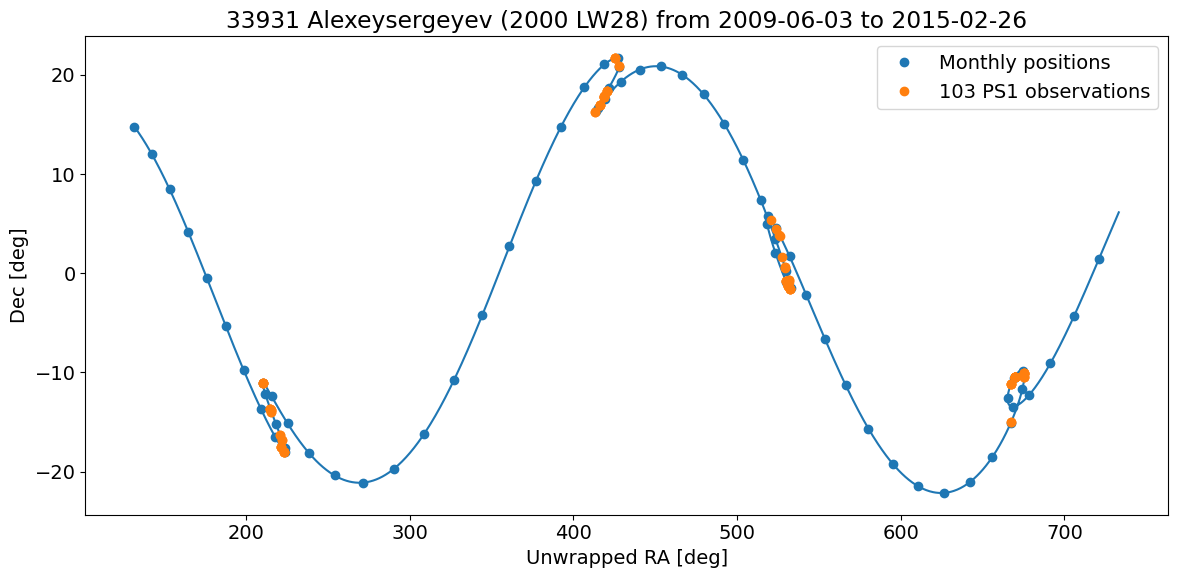

In [58]:
%%time 

# PS1 epoch range with epoch edges set to round days
emin = Time(54985.0, format='mjd')
emax = Time(57079.0, format='mjd')

print(f"Searching for {source} from {emin.isot} to {emax.isot} ({emax.mjd-emin.mjd:.0f} days)")

# query using 1-day time steps
obj = Horizons(id=source, location='F51', 
               epochs=dict(start=emin.isot, stop=emax.isot, step='1d'))#, 

jpltab = obj.ephemerides(extra_precision=True)
fullname = jpltab['targetname'][0]
print(f"Got positions from Horizons with {len(jpltab)} rows for {fullname}")

# undo RA-wrapping from 0-360 degrees
# add or subtract multiples of 360 to create a smooth path
njumps = 0
ratab = jpltab['RA'].data.copy()
w = np.where(ratab[1:] > ratab[:-1]+180)[0]
for k in w:
    njumps += 1
    ratab[k+1:] -= 360
w = np.where(ratab[1:] < ratab[:-1]-180)[0]
for k in w:
    njumps += 1
    ratab[k+1:] += 360
while ratab.min() < 0:
    ratab += 360

plt.rcParams.update({"font.size":14})
plt.figure(1,(12,6))
plt.plot(ratab, jpltab['DEC'])

# plot every 30 days as a dot to see movement
mstep = int(30/(jpltab['datetime_jd'][1]-jpltab['datetime_jd'][0]) + 0.5)
plt.plot(ratab[::mstep], jpltab['DEC'][::mstep], 'o', color="tab:blue", label="Monthly positions")

# show positions at the times of PS1 observations
jpl_mjd = Time(jpltab['datetime_jd'],format='jd').mjd
ra_interp = np.interp(cadc_tab['MJD'], jpl_mjd, ratab)
dec_interp = np.interp(cadc_tab['MJD'], jpl_mjd, jpltab['DEC'])
plt.plot(ra_interp, dec_interp, 'o', label=f"{len(cadc_tab)} PS1 observations") 

plt.xlabel("Unwrapped RA [deg]")
plt.ylabel("Dec [deg]")
plt.legend(loc="best")
plt.title(f"{fullname} from {emin.isot[:10]} to {emax.isot[:10]}")
plt.tight_layout()
if saveplots:
    plt.savefig("sky_path.png", facecolor="white")

## Extract JPEG cutout images to see whether the object is there

Note some images are blank or have artifacts near the source positions.  Approximately half of the positions have data at the center.  That will be typical for these moving object queries.

Blank images have a minimum value of 255 (all white), so they are easily excluded. 

There are ~100 cutout images of which ~60 are not completely blank.  That will be true for any object, although the exact numbers will vary depending on the fraction of observations where the object winds up in a gap in the camera.

In [59]:
%%time

imsize = 65 # cutout size in 0.25 arcsec pixels
output_size = 130

# cond = cadc_tab['Filter'] == 'g'
images = getimages(cadc_tab, size=imsize, output_size=output_size, verbose=True)
print(f"Got {len(images)} images")

# omit blank images
goodimages = []
igood = []
for i, image in enumerate(images):
    if image is not None and np.array(image).min() != 255:
        goodimages.append(image)
        igood.append(i)
ngood = len(goodimages)
igood = np.array(igood)
goodtab = cadc_tab[igood]
# add SrcID
goodtab.add_column(np.arange(len(goodtab)), name="SrcID", index=0)
print(f"{len(goodimages)} of {len(images)} are not blank")

83.2 s: completed 103 of 103 images
Got 103 images
74 of 103 are not blank
CPU times: user 1.48 s, sys: 130 ms, total: 1.61 s
Wall time: 1min 23s


## Show non-blank images in a grid

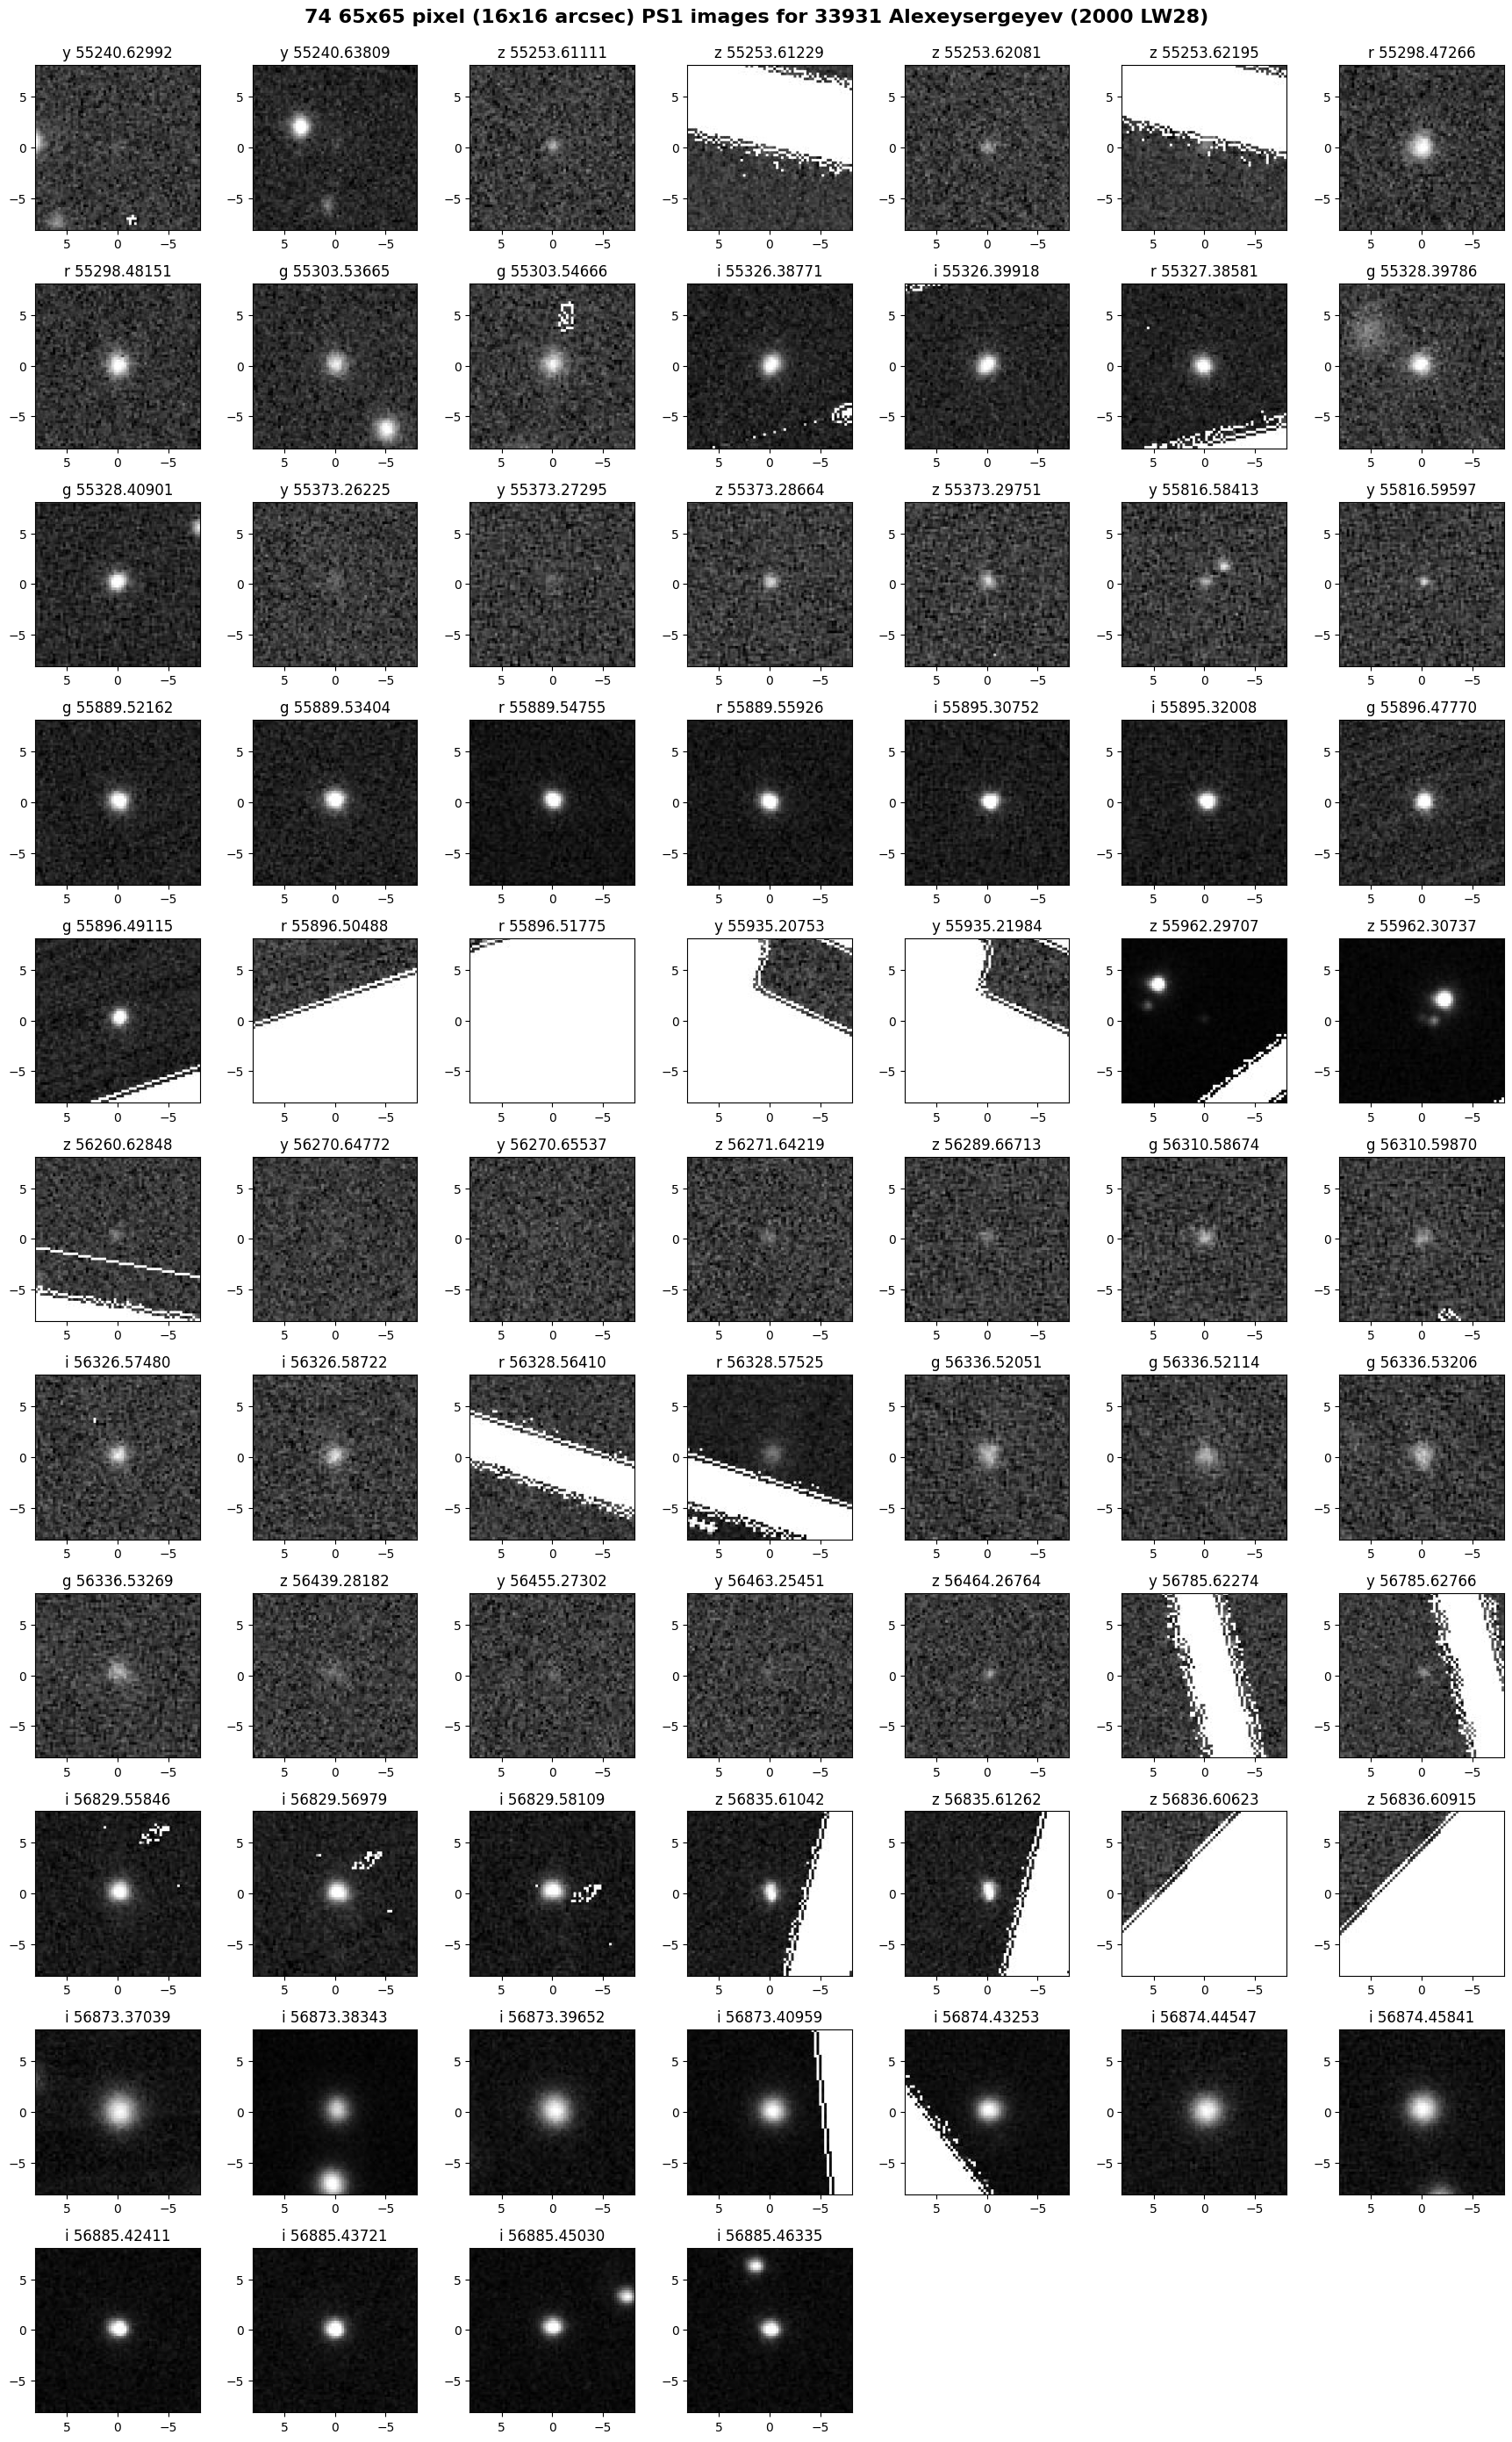

In [60]:
ncols = 7
nrows = (ngood+ncols-1)//ncols
hsize = ncols * 2.5
vsize = nrows * 2.5
extent = np.array([1,-1,-1,1])*0.25*imsize/2
plt.rcParams.update({"font.size":10})
plt.figure(1,(hsize,vsize))
for i in range(ngood):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(goodimages[i], origin="upper", cmap="gray", vmin=0, vmax=255, extent=extent)
    plt.title(f"{goodtab['Filter'][i]} {goodtab['MJD'][i]:.5f}")
plt.tight_layout()
plt.suptitle(f"{ngood} {imsize}x{imsize} pixel ({imsize/4:.0f}x{imsize/4:.0f} arcsec) PS1 images for {fullname}",
             y=1.01, fontsize=16, fontweight="bold")
if saveplots:
    plt.savefig("images.png",facecolor="white", bbox_inches="tight")

## Test: Extract some images at the original CADC positions to compare with the JPL positions

Select the first 14 images with shifts small enough to see on the image.  Then make a plot comparing the test images and the good images.

The first and third rows use the CADC position, and the second and fourth rows use the refined JPL Horizons position.  The image center is marked.  Clearly the updated JPL positions are much better when there is a shift.

This test is turned off by default since it is not needed for the example. Set `testing = True` to run it.

11.4 s: completed 14 of 14 images
Got 14 test images


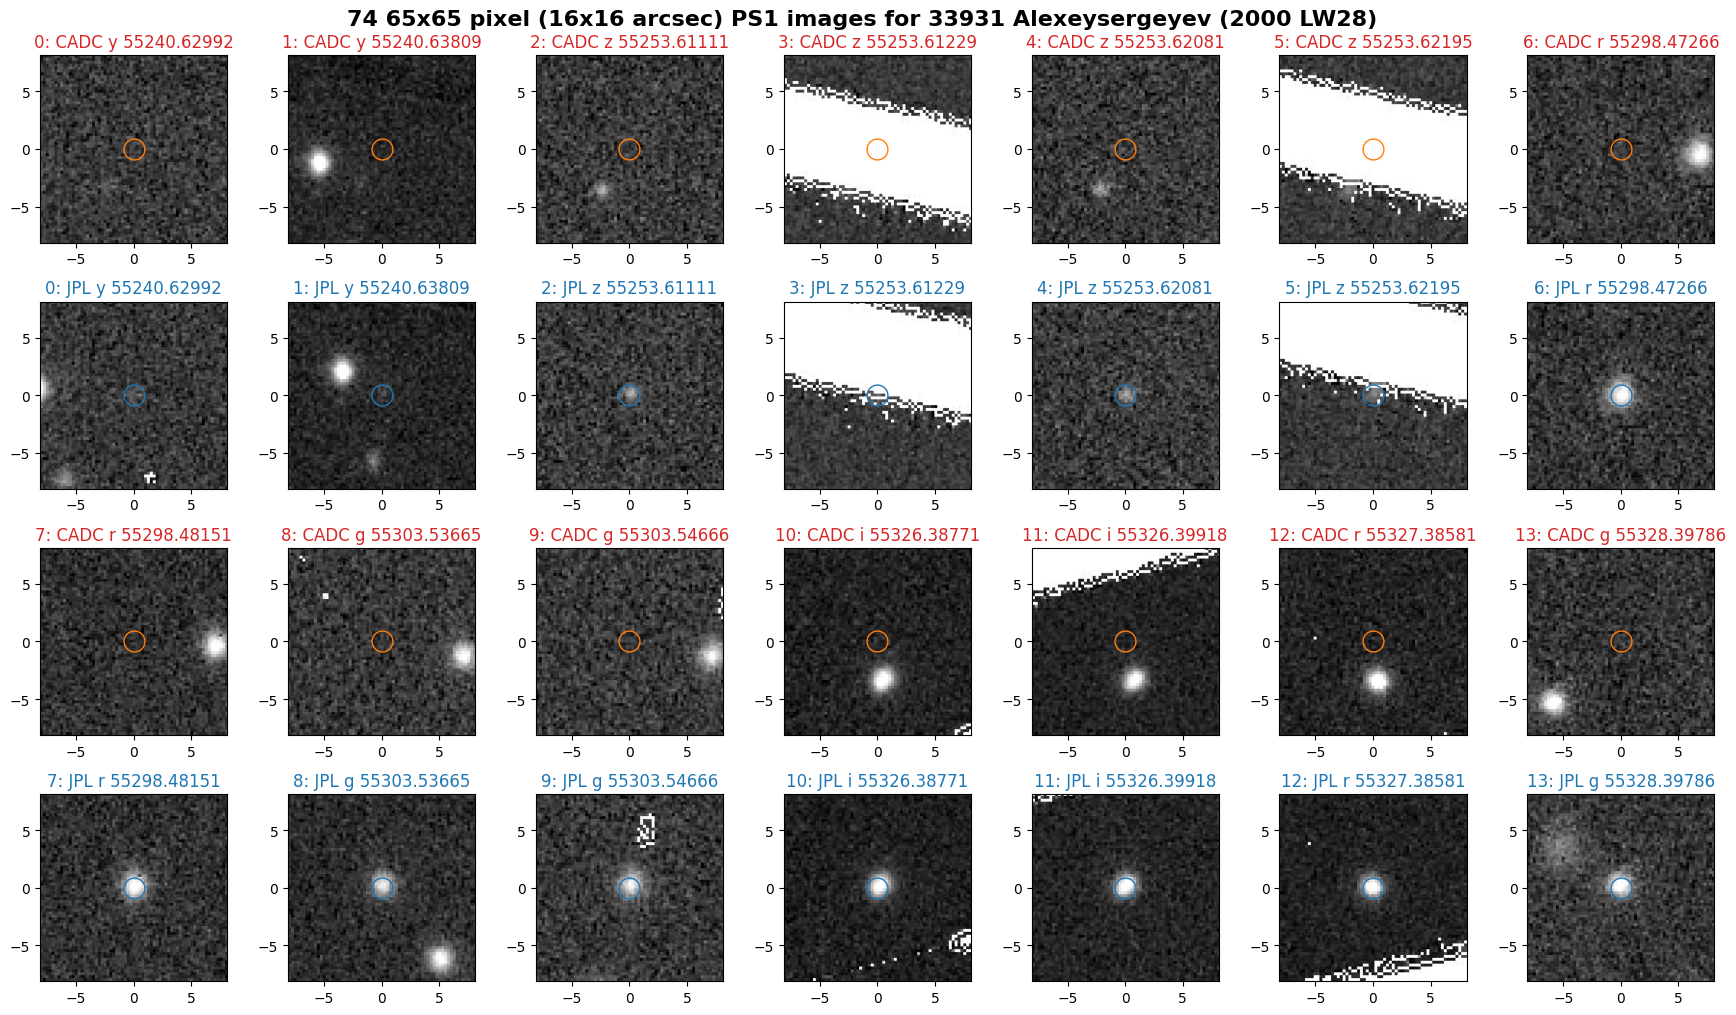

In [61]:
testing = True
if not testing:
    print("Not testing, skipped this step")
else:
    goodsep = np.sqrt(goodtab['dra'].data**2+goodtab['ddec'].data**2)
    itest = np.where(goodsep < 0.25*imsize/2)[0]
    itest = itest[:14]

    testimages = getimages(goodtab[itest], size=imsize, output_size=output_size, verbose=True,
                           racol='Object_RA', deccol='Object_Dec')
    print(f"Got {len(testimages)} test images")

    ncols = 7
    nrows = (len(itest)*2+ncols-1)//ncols
    hsize = ncols * 2.5
    vsize = nrows * 2.5
    extent = np.array([-1,1,-1,1])*0.25*imsize/2
    plt.rcParams.update({"font.size":10})
    plt.figure(1,(hsize,vsize))
    for i in range(len(itest)):
        j = itest[i]
        plt.subplot(nrows,ncols,i+1+(i//ncols)*ncols)
        plt.imshow(testimages[i], origin="upper", cmap="gray", vmin=0, vmax=255, extent=extent)
        plt.plot(0.0, 0.0, 'o', color="tab:orange", markerfacecolor="none", markersize=15)
        plt.title(f"{goodtab['SrcID'][j]}: CADC {goodtab['Filter'][j]} {goodtab['MJD'][j]:.5f}", color="tab:red")
        plt.subplot(nrows,ncols,i+1+(i//ncols+1)*ncols)
        plt.imshow(goodimages[j], origin="upper", cmap="gray", vmin=0, vmax=255, extent=extent)
        plt.plot(0.0, 0.0, 'o', color="tab:blue", markerfacecolor="none", markersize=15)
        plt.title(f"{goodtab['SrcID'][j]}: JPL {goodtab['Filter'][j]} {goodtab['MJD'][j]:.5f}", color="tab:blue")
    plt.tight_layout()
    _ = plt.suptitle(f"{ngood} {imsize}x{imsize} pixel ({imsize/4:.0f}x{imsize/4:.0f} arcsec) PS1 images for {fullname}",
                     y=1.01, fontsize=16, fontweight="bold")

## Upload the final match table and extract Detection table information

This creates a table `MyDB.jplhorizons3` in CasJobs and then does a cross-match to the `ObjectThin` and `Detection` tables.

The constraints are:
* Search radius 2 arcsec
* MJD match within half of exposure time (typically 15-20 sec)

The matched objects that are found are never close to these limits.

Note the `filterID` is not included in the constraints.  It could be included, but that does not seem necessary given the tight constraint on MJD. There is only one exposure in a single filter at any given time.  The next code blocks checks for any filter mismatches, but should not ever find any problems unless there are errors in the database.

If you do not want to see the images, this crossmatch can work from the original `cadc_tab` rather than the good images list in `goodtab`.  That will return the same number of matches.

In [19]:
%%time

# convert table to a csv string
cnames = ["SrcID", "ra", "dec", "Filter", "MJD"]
with StringIO() as fh:
    goodtab[cnames].write(fh, format="ascii.csv")
    hdata = fh.getvalue()

table = "jplhorizons3"

jobs = mastcasjobs.MastCasJobs(context="MyDB", request_type="POST")
jobs.drop_table_if_exists(table)
print(f"Dropped MyDB.{table}")

jobs.upload_table(table, hdata, exists=False)
print(f"Uploaded table to MyDB.{table}")
 
query = f"""
select t.SrcID, dbo.fDistanceArcminEq(d.ra,d.dec,t.ra,t.dec)*60 as darcsec,
    t.ra as hra, t.dec as hdec,
    t.filter as hfilter, t.mjd as hmjd,
    d.objID, d.detectID, d.filterID, d.imageID, d.obsTime, d.ra, d.dec,
    d.raErr, d.decErr, d.expTime, d.psfFlux, d.psfFluxErr, 
    d.psfMajorFWHM, d.psfMinorFWHM, d.psfTheta, d.psfCore, 
    d.psfQfPerfect, d.psfChiSq, d.apFlux, d.apFluxErr, 
    d.infoFlag, d.infoFlag2, d.infoFlag3
from MyDB.{table} t 
cross apply fGetNearbyObjEq(t.ra, t.dec, 2.0/60.0) nb
join Detection d on nb.objid=d.objid and d.obsTime between t.mjd-0.5*d.expTime/86400 and t.mjd+0.5*d.expTime/86400
order by d.obsTime, darcsec
"""

dtab = jobs.quick(query, context="PanSTARRS_DR2")
print(f"Retrieved {len(dtab)} row table")

dtab['filterID'] = dtab['filterID'].astype(np.uint8)
dtab['darcsec'].format = ".2f"
for c in ('hmjd','obsTime'):
    dtab[c].format = ".5f"
dtab

Dropped MyDB.jplhorizons3
Uploaded table to MyDB.jplhorizons3
Retrieved 54 row table
CPU times: user 86.8 ms, sys: 6.15 ms, total: 93 ms
Wall time: 7.35 s


<Table length=54>
SrcID darcsec    hra        hdec    hfilter     hmjd          objID        ... psfChiSq    apFlux    apFluxErr   infoFlag infoFlag2 infoFlag3
int64 float64  float64    float64     str1    float64         int64        ... float64    float64     float64     int64     int64     int64  
----- ------- ---------- ---------- ------- ----------- ------------------ ... -------- ----------- ----------- --------- --------- ---------
    0    0.25  36.035535  -4.981386       y 55077.54438 102020360354462656 ...  1.03185 0.000192844 3.25241e-06  35651585         0   7342144
    1    0.36  36.035833  -4.983035       y 55077.55736 102020360358820764 ...  1.02154 0.000169916 3.02852e-06  35651585         0   7342144
    2    0.06 178.887799    8.00655       z 55566.65106 117601788877718397 ...   1.1408 0.000106523 1.64003e-06 102760517       128   7374912
    3    0.01 178.888334   8.006742       z 55566.65408 117601788883008626 ...  1.15073 0.000123447 1.77991e-06 102760453       128   7374912
    4    0.02 181.447542   10.31845       z 55588.65363 120381814475582632 ...  1.19576  2.1033e-05 7.28739e-07 102760453       128   7372800
    5    0.03 181.447932  10.320086       z 55588.66486 120381814479544589 ...  1.15698 0.000171011 2.06097e-06 102760517       128   7374912
    6    0.01  181.51866  10.617031       y 55590.64540 120741815186650958 ...  1.08411 0.000221987 3.76328e-06 102760453       128   7374912
    7    0.02 181.561165  10.927175       y 55592.62364 121111815611613090 ...  1.16676 0.000202674 3.45437e-06 102760517       128   7374912
    8    0.07 173.855087  20.855278       i 55650.29485 133021738551026891 ...  1.15848 0.000312271 2.02024e-06 102760517       128   7374912
  ...     ...        ...        ...     ...         ...                ... ...      ...         ...         ...       ...       ...       ...
   53    0.01 345.172978 -18.938443       y 56631.19831  85273451729734239 ...  1.09923 3.69323e-05  9.8723e-07  35653633         0   7374912
   54    0.26   110.4781    8.25453       z 56966.64570 117901104780595994 ... 0.842179 0.000190898 4.18852e-06  35651585         0   7342144
   55    0.13 110.479697   8.254088       y 56966.65796 117901104796825440 ...  1.08907 0.000221701 3.70002e-06  35651585         0   7342144
   56    0.01 111.494834   8.125761       i 56995.52240 117751114948361435 ...   1.1133 0.000281932 1.92512e-06 102760517       128   7342144
   57    0.05 110.383432   8.672257       r 57005.54157 118401103834407195 ...  1.12414 0.000313644 4.16359e-06  35651585       128   7342144
   58    0.05 110.381517   8.673144       r 57005.55380 118401103815258247 ...  1.08722 0.000363009 3.99466e-06 102760453       128   7342144
   61    0.02  109.74337   8.995521       r 57009.55942 118791097433615131 ...   1.1135 0.000351985 2.53235e-06 102760517       128   7342144
   62    0.04 109.741323   8.996505       r 57009.57070 118791097413176319 ...  2.18683 0.000417116 2.23079e-06 102776839       128   7374912
   63    0.01 109.739316   8.997471       r 57009.58177 118791097393087465 ...  1.15616  0.00035511 2.04687e-06 102760517       128   7374912
   64    0.02 109.737336   8.998425       r 57009.59271 118791097373378600 ...  1.20155 0.000337035 1.99653e-06 102760517       160   7374912

## Check for mismatches in filter or time

Also checks to see whether any `SrcID` entries have duplicate matches.  That can happen if the object happens to be moving through a very crowded region such as the Galactic plane.  If there are multiple matches, the closest one is retained.  (You might want to look more carefully at such cases, however.)

In [20]:
print((np.abs(dtab['hmjd']-dtab['obsTime']) > 0.00002).sum(), "sources with MJD discrepancy")
print((dtab['filterID'] != [("grizy".find(x)+1) for x in dtab['hfilter']]).sum(), "sources with filter discrepancy")
ndup = len(dtab)-len(np.unique(dtab['SrcID']))
print(f"{ndup} duplicate matches to same SrcID")
if ndup > 0:
    # pick closer of each duplicate entry
    dtab.sort(['SrcID', 'darcsec'])
    h = np.bincount(dtab['SrcID'])
    w = np.where(h > 1)[0]
    keep = np.ones(len(dtab), dtype=bool)
    for s in w:
        ww = np.where(dtab['SrcID']==s)[0]
        keep[ww[1:]] = False
    dtab = dtab[keep]
    print(f"Retaining {len(dtab)} entries with only closest for dups")
        
print(f"Maximum epoch difference: {(dtab['hmjd']-dtab['obsTime']).max()*86400:.4f} s")

0 sources with MJD discrepancy
0 sources with filter discrepancy
0 duplicate matches to same SrcID
Maximum epoch difference: 0.0070 s


## Scatterplot showing position differences between PS1 Detection and JPL Horizons

The position differences will be a combination of PS1 position errors and uncertainties in the object's ephemeris.  The `psfQfPerfect` flag is used to highlight likely poor quality detections that have bad pixels in the core of the PSF.  They account for the points that have large position errors.

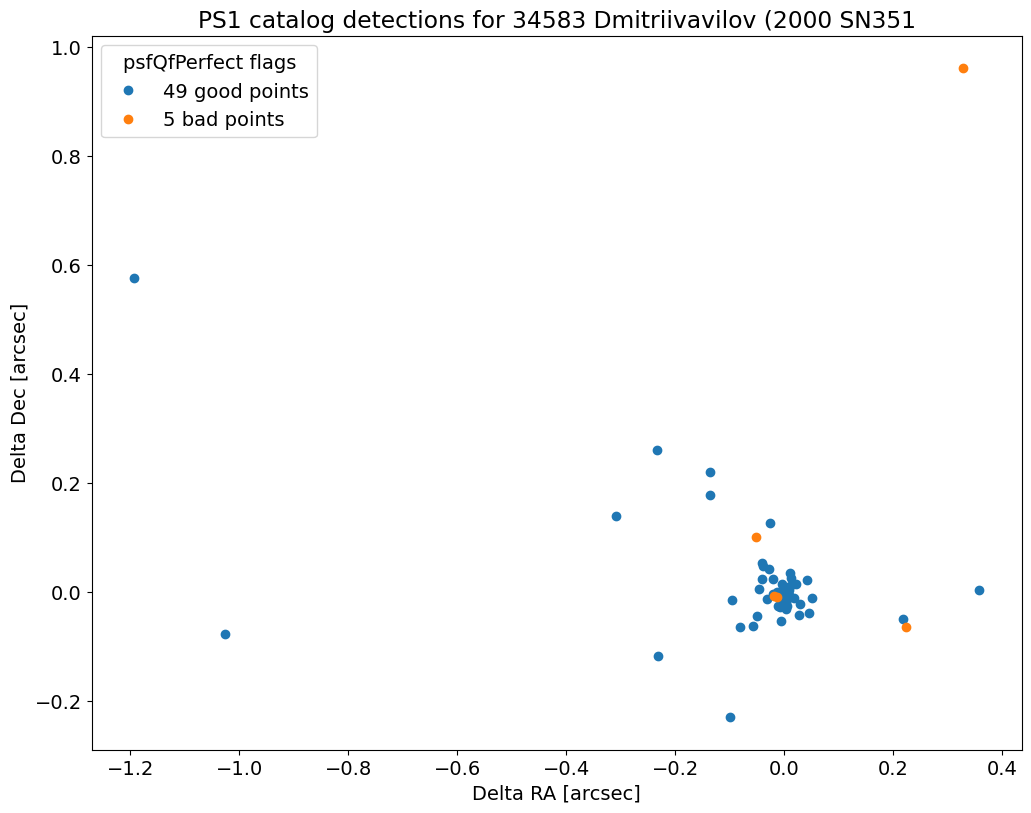

In [21]:
plt.rcParams.update({"font.size":14})
plt.figure(1,(12,12))
wgood = np.where(dtab['psfQfPerfect'] > 0.95)[0]
wbad = np.where(dtab['psfQfPerfect'] <= 0.95)[0]
dra = (dtab['ra']-dtab['hra'])*3600*np.cos(np.radians(dtab['hdec']))
ddec = (dtab['dec']-dtab['hdec'])*3600
plt.plot(dra[wgood], ddec[wgood], 'o', label=f"{len(wgood)} good points")
plt.plot(dra[wbad], ddec[wbad], 'o', label=f"{len(wbad)} bad points")
plt.xlabel("Delta RA [arcsec]")
plt.ylabel("Delta Dec [arcsec]")
plt.gca().set_aspect(1.0)
plt.legend(loc="best", title="psfQfPerfect flags")
plt.title(f"PS1 catalog detections for {fullname}")
if saveplots:
    plt.savefig("position-diffs.png", facecolor="white", bbox_inches="tight")

## Show images with sources in catalog marked

The shifts are usually too small to see, but this does show which of the images have PS1 detections and which do not.

Magnitudes are shown in the plot titles for detected objects.  A magnitude followed by `*` is dubious because it has `psfQfPerfect <= 0.95`, indicating that there are bad pixels in the core of the object.  The marker uses a different color to highlight those cases.

<div class="alert alert-block alert-info">
    <b>Note:</b> 
    The plotted positions are not strictly accurate.  The cutouts are centered on the nearest pixel from the PS1 image, which means they can be shifted by up to half a pixel (0.125 arcsec) from the requested coordinate system.  It would be more accurate to use the WCS for the cutout (which is available for FITS cutouts or in the comment section of JPEG cutouts) to compute the marker position.
</div>

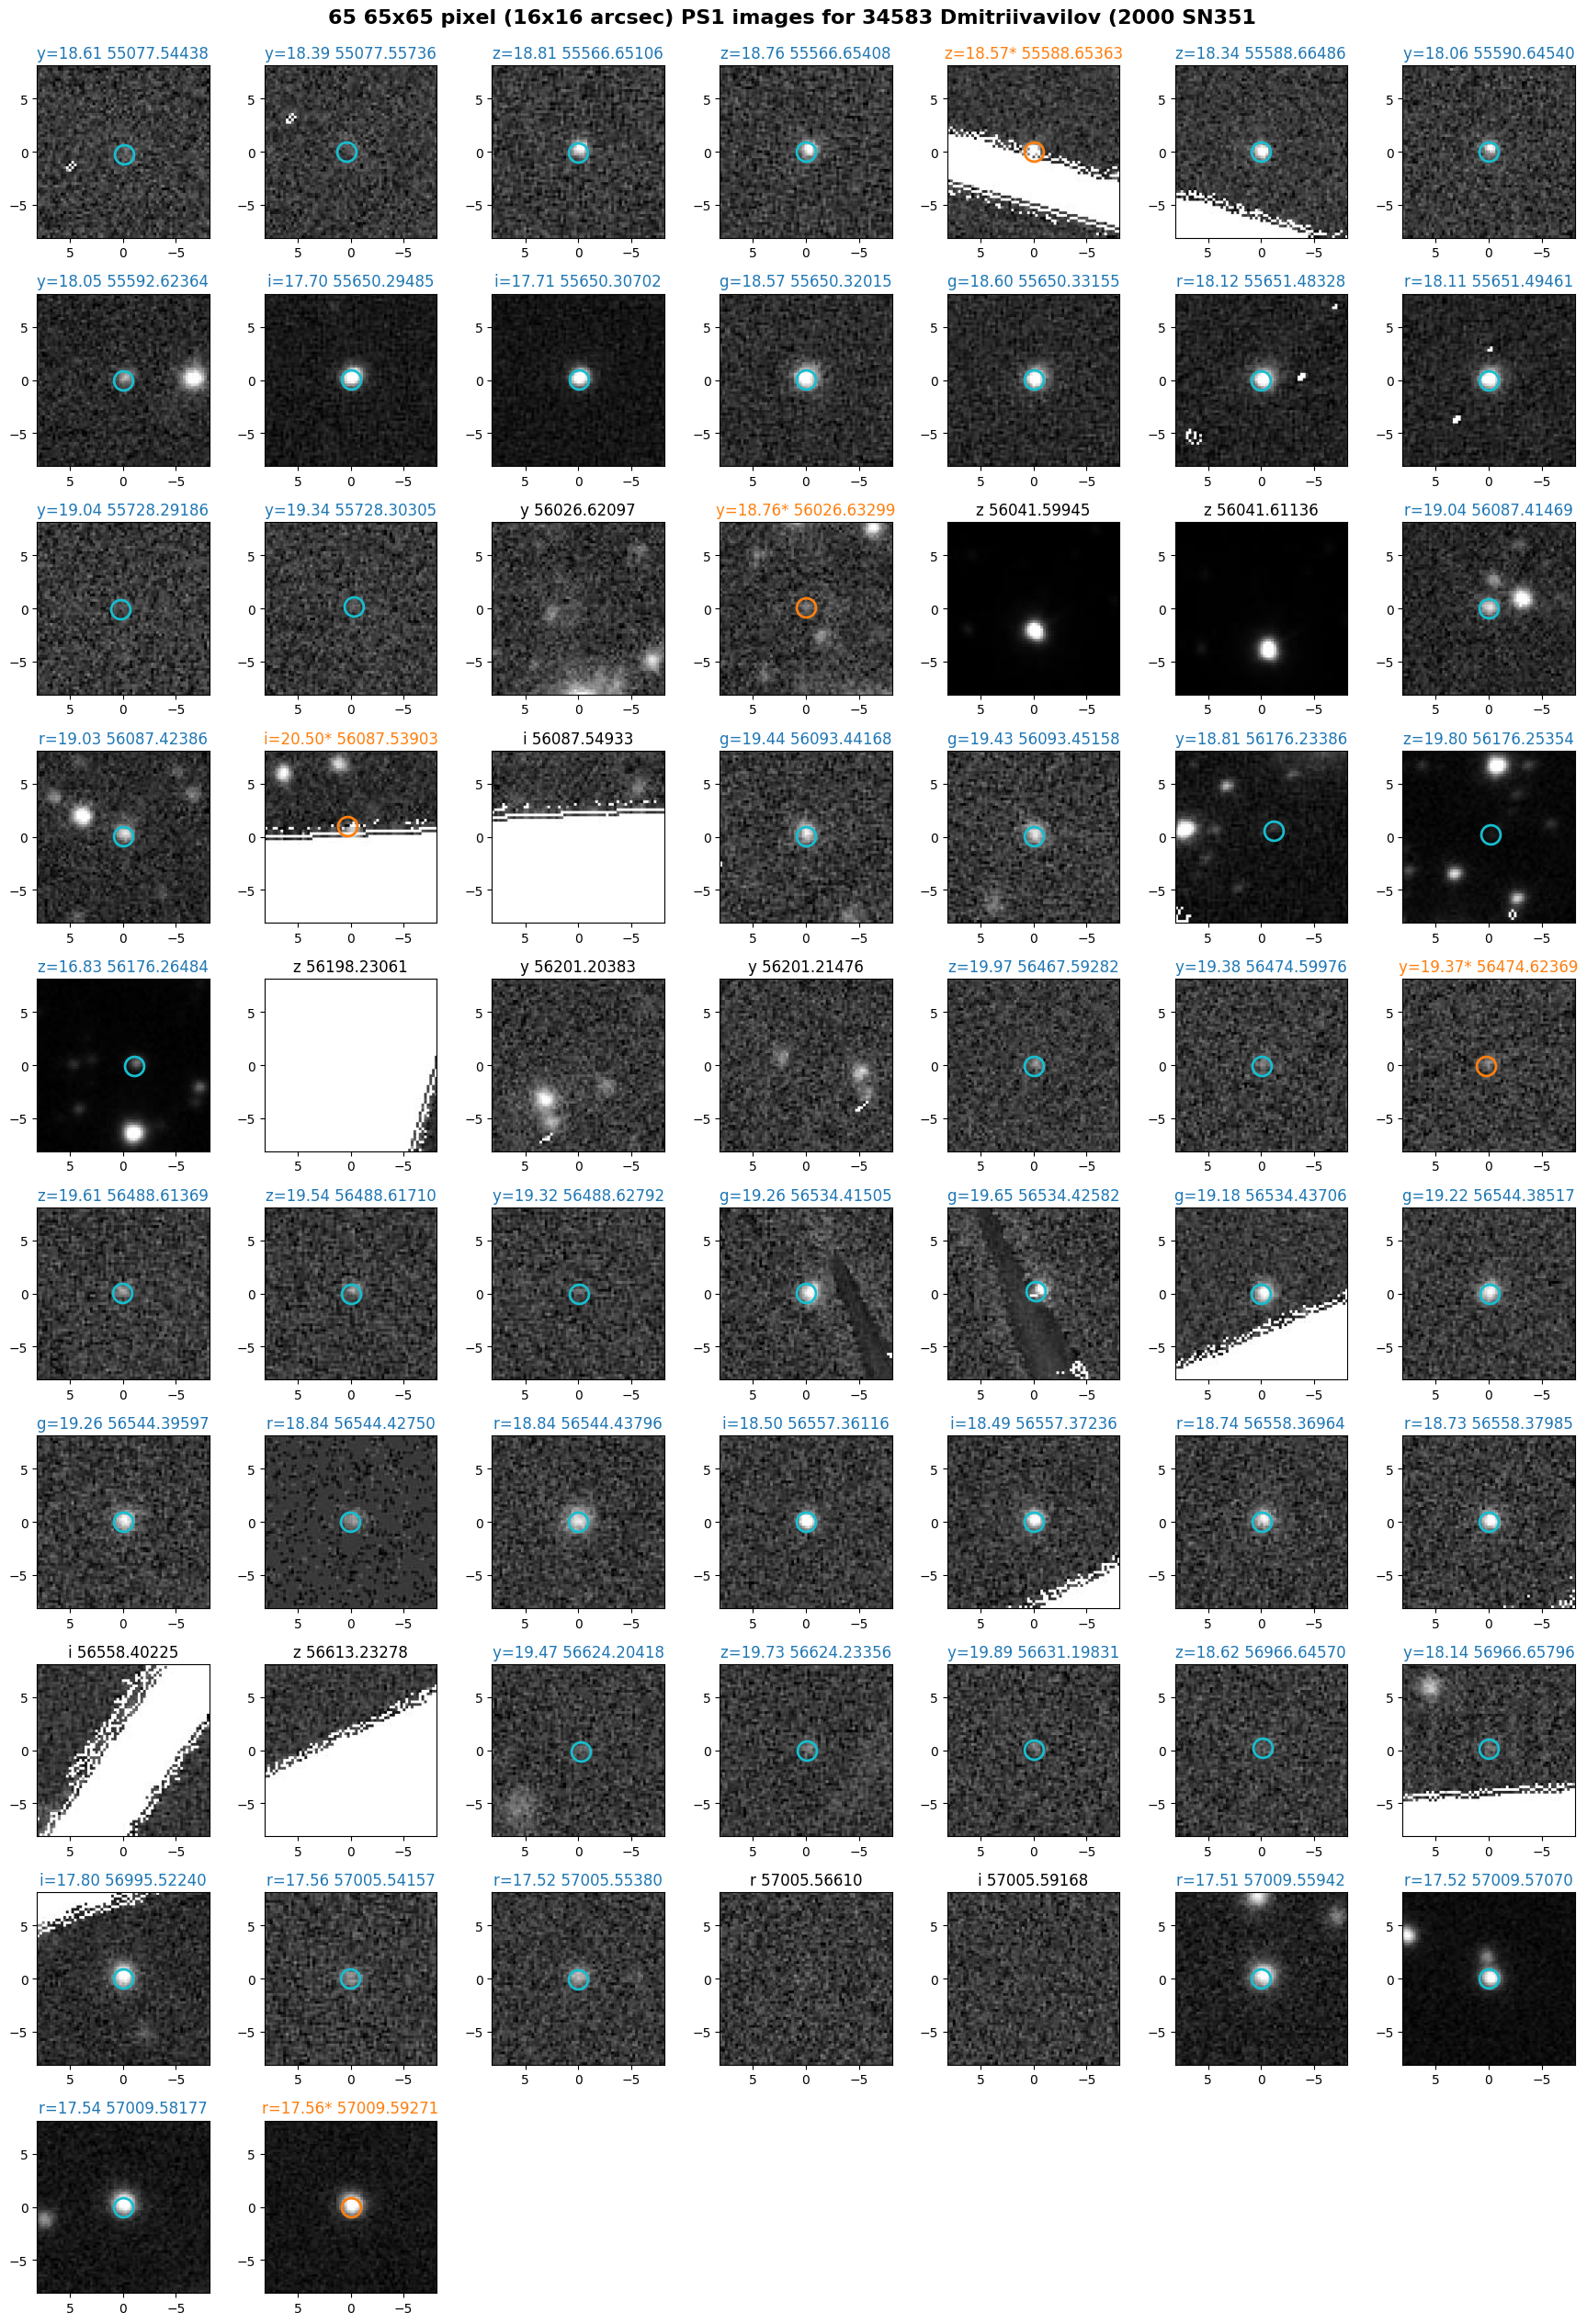

In [22]:
goodmatch = join(goodtab, dtab['SrcID','ra','dec','psfFlux','psfQfPerfect'], keys='SrcID', join_type='left')
# offset of source from center
dx = (goodmatch['ra_2']-goodmatch['ra_1'])*3600*np.cos(np.radians(goodmatch['dec_1']))
dy = (goodmatch['dec_2']-goodmatch['dec_1'])*3600

# convert the fluxes to AB magnitudes
mag = -2.5*np.log10(goodmatch['psfFlux']) + 8.90
goodmatch['mag'] = mag

ncols = 7
nrows = (ngood+ncols-1)//ncols
hsize = ncols * 2.5
vsize = nrows * 2.5
extent = np.array([1,-1,-1,1])*0.25*imsize/2

plt.rcParams.update({"font.size":10})
plt.figure(1,(hsize,vsize))
for i in range(ngood):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(goodimages[i], origin="upper", cmap="gray", vmin=0, vmax=255, extent=extent)
    if hasattr(goodmatch['ra_2'],'mask') and goodmatch['ra_2'].mask[i]:
        # no detection
        plt.title(f"{goodmatch['Filter'][i]} {goodmatch['MJD'][i]:.5f}")
    else:
        # show detection
        if goodmatch['psfQfPerfect'][i]<=0.95:
            # dubious magnitude
            warning = '*'
            color = "tab:orange"
            tcolor = color
        else:
            warning = ''
            color = "tab:cyan"
            tcolor = "tab:blue"
        plt.plot(dx[i], dy[i], 'o', color=color, markerfacecolor="none", markersize=15, markeredgewidth=2)
        plt.title(f"{goodmatch['Filter'][i]}={mag[i]:.2f}{warning} {goodmatch['MJD'][i]:.5f}",
                  color=tcolor)
plt.tight_layout()
# print(f"{ngood} {imsize}x{imsize} pixel ({imsize/4:.0f}x{imsize/4:.0f} arcsec) PS1 images for {fullname}")
plt.suptitle(f"{ngood} {imsize}x{imsize} pixel ({imsize/4:.0f}x{imsize/4:.0f} arcsec) PS1 images for {fullname}",
             y=1.01, fontsize=16, fontweight="bold")
if saveplots:
    plt.savefig("images-catalogs.png", facecolor="white", bbox_inches="tight")

## Plot light curve

This removes poor quality measurements using the `psfQfPerfect > 0.95` test.  It also shows a plot with the magnitudes corrected using a simple model determined by the illumination fraction and distance to the object.

Note that the model does account for most of the variation in apparent brightness.

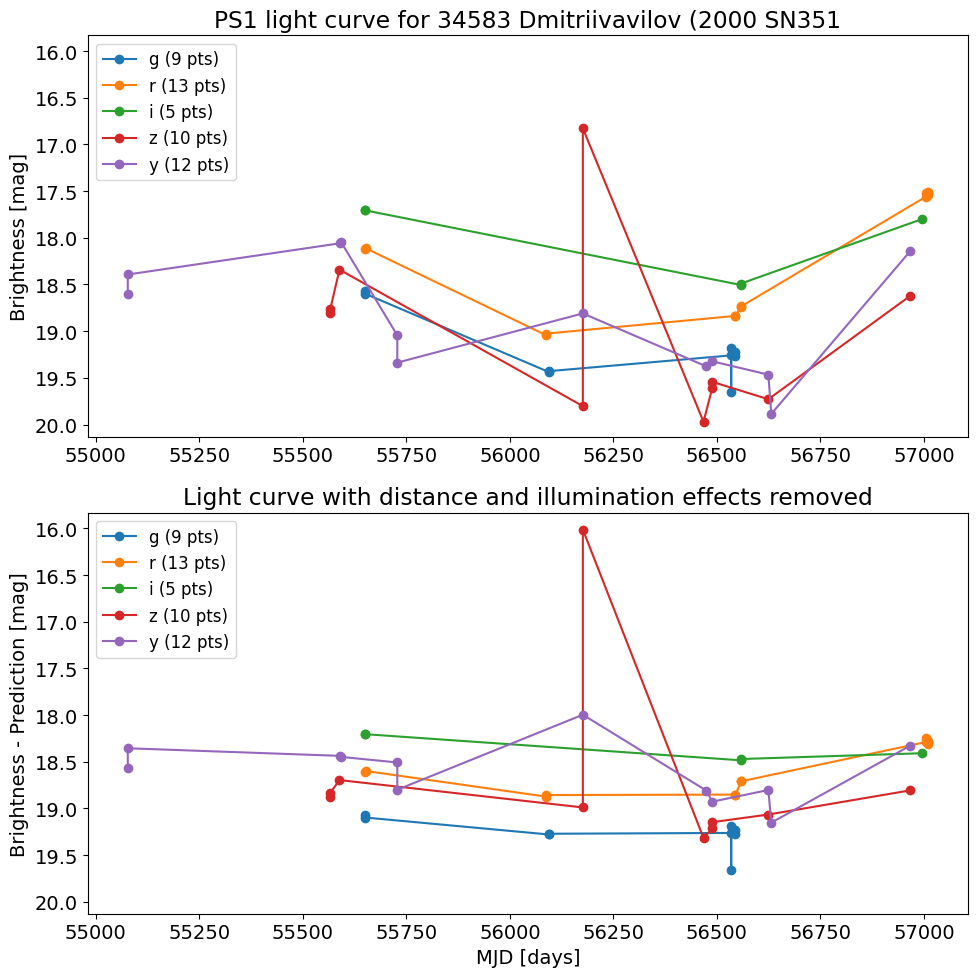

In [23]:
jdtab = join(dtab, goodtab['SrcID','illumination','delta'])
assert len(jdtab) == len(dtab)
jdtab['mag'] = -2.5*np.log10(jdtab['psfFlux']) + 8.90

# illumination magnitude factor
jdtab['illumfac'] = -2.5*np.log10(jdtab['illumination']/jdtab['delta']**2)
jdtab['illumfac'] -= jdtab['illumfac'].mean()

fdtab = jdtab.group_by('filterID')

plt.rcParams.update({"font.size":14})
plt.figure(1,(10,10))
sub1 = plt.subplot(2,1,1)
for g in fdtab.groups:
    hfilter = g['hfilter'][0]
    ww = np.where(g['psfQfPerfect']>0.95)[0]
    lines = plt.plot(g['hmjd'][ww], g['mag'][ww], 'o-',label=f"{hfilter} ({len(ww)} pts)")
# plt.xlabel("MJD [days]")
plt.ylabel("Brightness [mag]")
ylim = plt.ylim()[::-1]
plt.legend(loc="upper left", fontsize=12)
plt.title(f"PS1 light curve for {fullname}")

sub2 = plt.subplot(2,1,2)
for g in fdtab.groups:
    hfilter = g['hfilter'][0]
    ww = np.where(g['psfQfPerfect']>0.95)[0]
    plt.plot(g['hmjd'][ww], g['mag'][ww]-g['illumfac'][ww], 'o-', label=f"{hfilter} ({len(ww)} pts)")
plt.xlabel("MJD [days]")
ylim2 = plt.ylim()[::-1]
ylim = (max(ylim[0],ylim2[0]), min(ylim[1],ylim2[1]))
sub2.set_ylim(ylim)
sub1.set_ylim(ylim)
plt.ylabel("Brightness - Prediction [mag]")
plt.legend(loc="upper left", fontsize=12)
plt.title("Light curve with distance and illumination effects removed")
plt.tight_layout()
if saveplots:
    plt.savefig("light-curves.png", facecolor="white")